In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles
import networkx as nx

In [31]:
save_path = "/Users/niklaskiermeyer/Desktop/Codespace/DruxAI/data/preprocessed/"

In [32]:
df = pd.read_csv(save_path + "auc_secondary_screen_prediction_targets.csv", index_col=0)
df.head()

,cell_line,DRUG,auc,smiles,logauc,auc_per_drug,means,stds,range
0,ACH-000879,CYTARABINE,1.677789,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,0.517477,2.367402,0.228684,0.121987,0.782691
1,ACH-000320,CYTARABINE,1.240300,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,0.215353,-0.109281,0.228684,0.121987,0.782691
2,ACH-001145,CYTARABINE,1.472333,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,0.386848,1.296560,0.228684,0.121987,0.782691
3,ACH-000873,CYTARABINE,1.207160,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,0.188270,-0.331294,0.228684,0.121987,0.782691
4,ACH-000855,CYTARABINE,1.229332,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,0.206471,-0.182097,0.228684,0.121987,0.782691


In [33]:
drug_smiles_data = df[["DRUG", "smiles"]].drop_duplicates()

# drug_smiles_data.head()

drug_smiles_data.to_csv(save_path + "drug_smiles_with_targets.csv")

unique_drugs = drug_smiles_data.drop_duplicates(subset=["DRUG", "smiles"])[["DRUG", "smiles"]]
drug_smiles_data.to_csv(save_path + "unique_drugs_and_smiles.csv")

         DRUG                                            smiles  auc_per_drug
0  CYTARABINE  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1      2.367402
1  CYTARABINE  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1     -0.109281
2  CYTARABINE  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1      1.296560
3  CYTARABINE  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1     -0.331294
4  CYTARABINE  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1     -0.182097


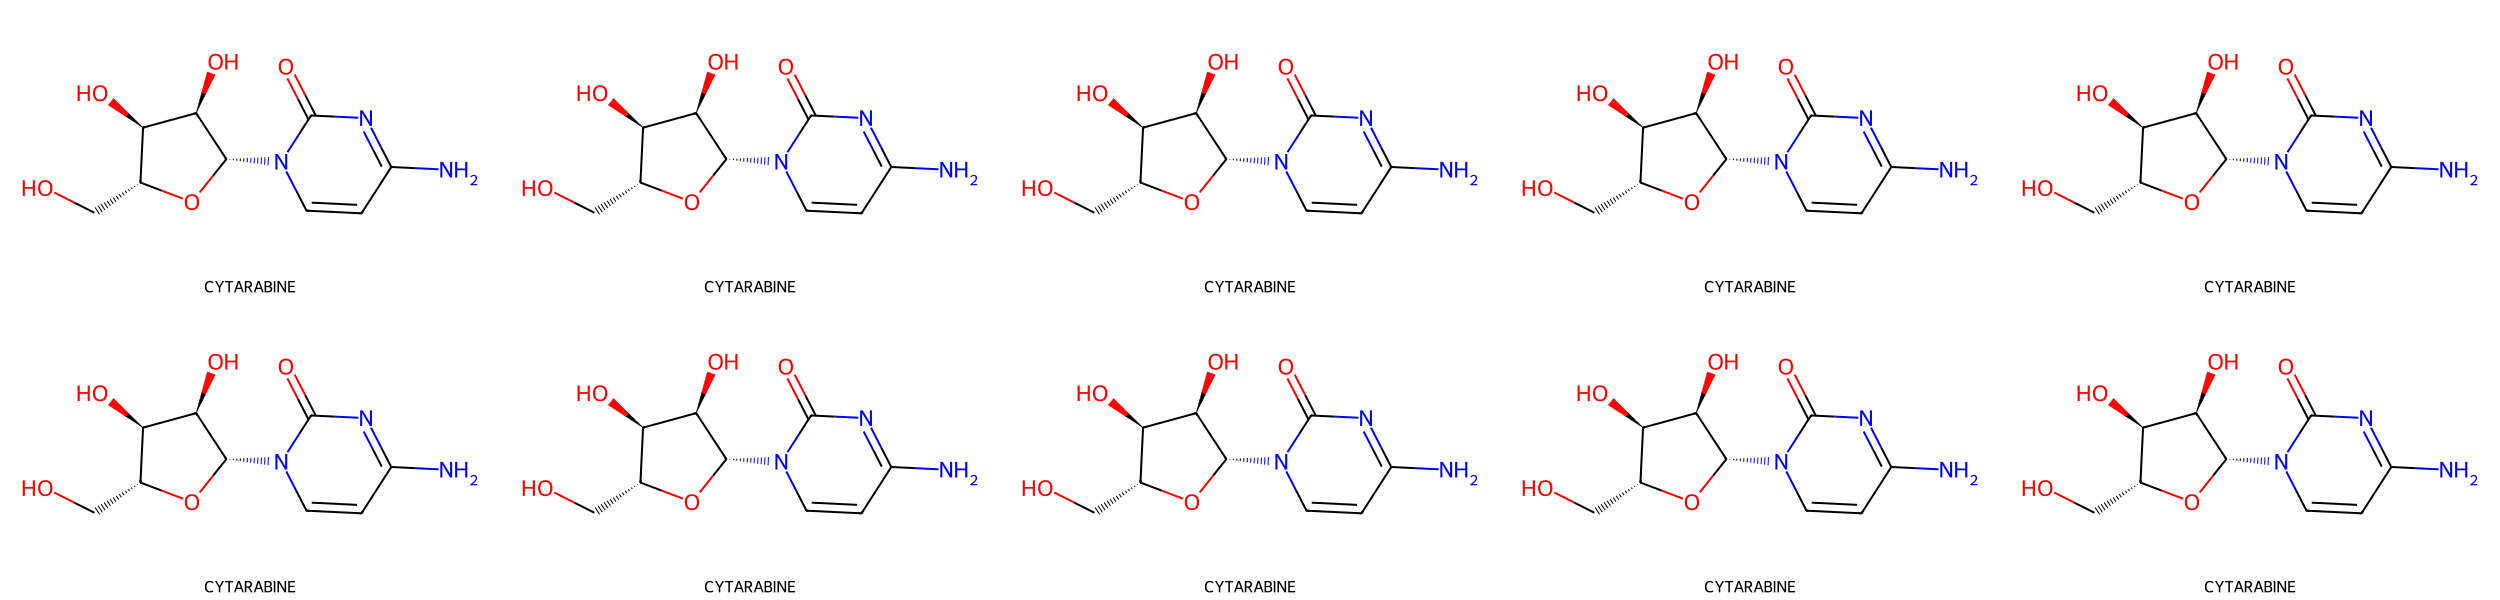

In [17]:
sampled_data = drug_smiles_data[:10] #.sample(n=10)
print(sampled_data.head())

m_list = [Chem.MolFromSmiles(sm) for sm in sampled_data["smiles"]]
img = Draw.MolsToGridImage(m_list, subImgSize=(500,300), molsPerRow=5,
                           legends  = [name for name in sampled_data["DRUG"]])
img

In [23]:
# Define a custom dataset for SMILES data
class SMILESDataset(torch.utils.data.Dataset):
    def __init__(self, smiles_list, labels):
        self.smiles_list = smiles_list
        self.labels = labels

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smile = self.smiles_list[idx]

        mol = MolFromSmiles(smile)
        mol = Chem.AddHs(mol)  # Add Hydrogens
        AllChem.EmbedMolecule(mol, AllChem.ETKDG()) # Generate 3D coordinates
        adj_matrix = Chem.GetAdjacencyMatrix(mol)
        edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long).t().contiguous()

        features = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.float)
        # label = torch.tensor(self.labels[idx], dtype=torch.float)

        return Data(x=features, edge_index=edge_index, y=features)

In [19]:
Smiles_df = SMILESDataset(drug_smiles_data["smiles"].to_list(),
                          drug_smiles_data["auc_per_drug"].to_list())

In [20]:
Smiles_df[0].y

tensor([7., 6., 6., 6., 7., 6., 8., 6., 6., 8., 6., 8., 6., 8., 6., 8., 7., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

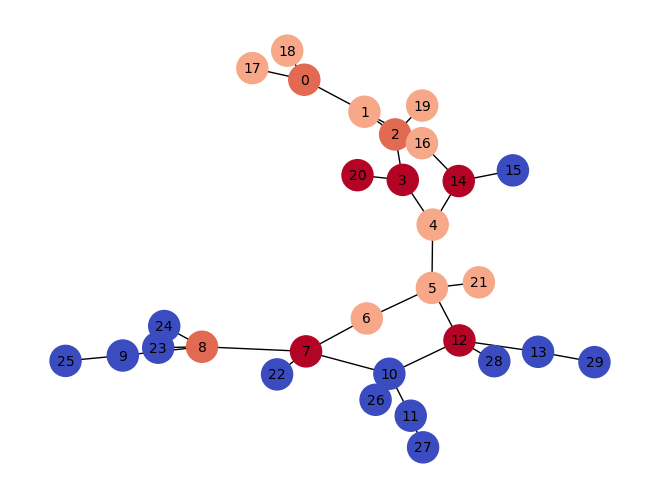

In [21]:
# Create an empty graph
G = nx.Graph()

# Add edges from edge_index
G.add_edges_from(Smiles_df[0].edge_index.cpu().numpy())

# Get node features
node_features = Smiles_df[0].x.cpu().numpy()

# Define colors based on node features
node_colors = [feature for feature in node_features]

# Draw the graph with node labels and colors based on features
nx.draw(G, with_labels=True, node_color=node_colors, cmap="coolwarm", node_size=500, font_size=10, edge_color="black",
        linewidths=1, pos=nx.spring_layout(G))

# Show the plot
plt.show()

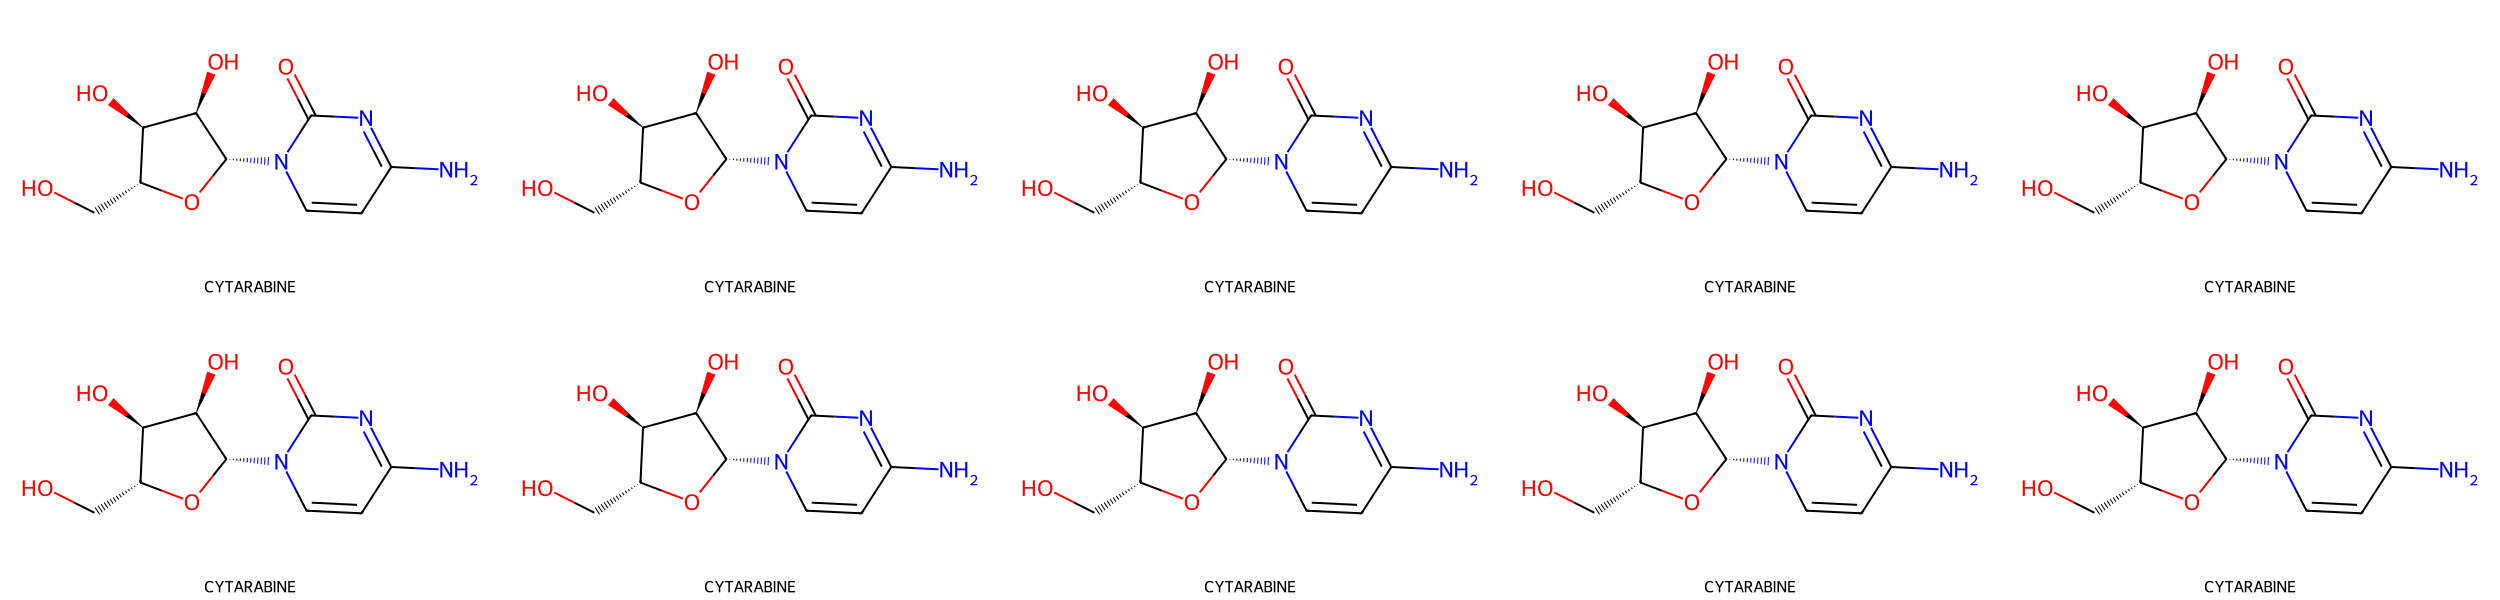

In [22]:
img